# Introduction

This is demonstration of data from the Community Health Outreach data set. This is for the class MSIS 671 at the University of Massachusetts Boston as a supplment to the homework. This notebok is creating a predictive model for Inpatient Psychiatric Services based on several patient characteristics. It uses a Random Forest model. 

# Data Preparation

## Load packages

In [1]:
# Main Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.pyplot as plt1

# XGBoost
import xgboost as xgb

# SiKit
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn.preprocessing import LabelEncoder

#DMBA
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary

# Graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# Imblearner
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss

# Collections
from collections import Counter

# Plotly
import plotly.express as px
import plotly.figure_factory as ff

## Get Data

Get data from the Community Health Outreach data set, filtering it down to eight variables for testing.

In [2]:
CHO1_df = pd.read_csv('CommunityHealthRoster_Demo.csv')
CHO1_df.columns 
CHO1_df= CHO1_df[['Inpatient_Psych_Service',
                   'Num_Social_Risk_Factors',
                   'Sex',
                   'Emergency_Dept_Service',
                   'Alcohol_or_Drug_Diagnosis',
                   'Major_Depressive_Disorder_Diagnosis',
                   'Race_Black_Indigenous_PeopleOfColor',
                   'Employed']]

## Wrangle Data

In [3]:
CHO1_df.dtypes

Inpatient_Psych_Service                  int64
Num_Social_Risk_Factors                  int64
Sex                                     object
Emergency_Dept_Service                   int64
Alcohol_or_Drug_Diagnosis                int64
Major_Depressive_Disorder_Diagnosis      int64
Race_Black_Indigenous_PeopleOfColor    float64
Employed                                 int64
dtype: object

Check for NaN values in the data

In [4]:
## check missing values
pd.isna(CHO1_df).sum()

Inpatient_Psych_Service                  0
Num_Social_Risk_Factors                  0
Sex                                      0
Emergency_Dept_Service                   0
Alcohol_or_Drug_Diagnosis                0
Major_Depressive_Disorder_Diagnosis      0
Race_Black_Indigenous_PeopleOfColor    273
Employed                                 0
dtype: int64

Race_BIPOC has 273 NaN values indicating that the item was not completed by the member. It cannot be assumed that NaN is the same as 0 in this case.

Further explore to see proportion of values in Race_BIPOC

In [5]:
# Count the number of each unique value in the specified column
value_counts = CHO1_df['Race_Black_Indigenous_PeopleOfColor'].value_counts(dropna=False)

# Calculate the percentage for each unique value
total_values = len(CHO1_df['Race_Black_Indigenous_PeopleOfColor'].dropna())
percentage = value_counts / total_values * 100

# Display the counts and percentages
result_df = pd.DataFrame({'Count': value_counts, 'Percentage': percentage})
print("\nNumber and Percentage of each unique value:")
print(result_df)


Number and Percentage of each unique value:
                                     Count  Percentage
Race_Black_Indigenous_PeopleOfColor                   
0.0                                  52111   89.837258
1.0                                   5895   10.162742
NaN                                    273    0.470641


Race_BIPOC has 273 NaN values indicating that the item was not completed. The following code will impute values 0 and 1 according to the given proportions of existing data, 89.84/10.16.

In [6]:
# Assuming CHO1_df is your DataFrame and 'Race_Black_Indigenous_PeopleOfColor' is the column
nan_indices = CHO1_df['Race_Black_Indigenous_PeopleOfColor'].index[CHO1_df['Race_Black_Indigenous_PeopleOfColor'].isna()]
random_values = np.random.choice([0, 1], size=len(nan_indices), p=[0.8984, 0.1016])

# Replace NaN values with random values
CHO1_df.loc[nan_indices, 'Race_Black_Indigenous_PeopleOfColor'] = random_values

Check Race BIPOC again to make sure it is free of NaN

In [7]:
# Count the number of each unique value in the specified column
value_counts = CHO1_df['Race_Black_Indigenous_PeopleOfColor'].value_counts(dropna=False)

# Calculate the percentage for each unique value
total_values = len(CHO1_df['Race_Black_Indigenous_PeopleOfColor'].dropna())
percentage = value_counts / total_values * 100

# Display the counts and percentages
result_df = pd.DataFrame({'Count': value_counts, 'Percentage': percentage})
print("\nNumber and Percentage of each unique value:")
print(result_df)


Number and Percentage of each unique value:
                                     Count  Percentage
Race_Black_Indigenous_PeopleOfColor                   
0.0                                  52366   89.853978
1.0                                   5913   10.146022


Check again for missing values in data set

In [8]:
## check missing values
pd.isna(CHO1_df).sum()

Inpatient_Psych_Service                0
Num_Social_Risk_Factors                0
Sex                                    0
Emergency_Dept_Service                 0
Alcohol_or_Drug_Diagnosis              0
Major_Depressive_Disorder_Diagnosis    0
Race_Black_Indigenous_PeopleOfColor    0
Employed                               0
dtype: int64

Convert Inpatient Psych Service to a string so it can be considered as a class.

In [9]:
# Convert the column to strings
CHO1_df['Inpatient_Psych_Service'] = CHO1_df['Inpatient_Psych_Service'].astype(str)

Convert Race_BIPOC to integer so it can be a predictor

In [10]:
# Convert Race_BIPOC to Integer
CHO1_df['Race_Black_Indigenous_PeopleOfColor'] = CHO1_df['Race_Black_Indigenous_PeopleOfColor'].astype(int)

### Dummy Variables

Convert Sex to dummy variables, dropping first.

In [11]:
# Convert categorical variables to dummy variables
CHO1_df = pd.get_dummies(CHO1_df, columns=['Sex'], prefix=['Sex'], drop_first=True)

In [12]:
CHO1_df.head()

,Inpatient_Psych_Service,Num_Social_Risk_Factors,Emergency_Dept_Service,Alcohol_or_Drug_Diagnosis,Major_Depressive_Disorder_Diagnosis,Race_Black_Indigenous_PeopleOfColor,Employed,Sex_M
0,0,0,0,0,0,0,0,False
1,0,0,1,1,1,0,0,True
2,0,0,0,0,0,0,0,False
3,0,1,0,1,0,0,0,False
4,0,0,1,0,0,0,0,False


In [13]:
CHO1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58279 entries, 0 to 58278
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Inpatient_Psych_Service              58279 non-null  object
 1   Num_Social_Risk_Factors              58279 non-null  int64 
 2   Emergency_Dept_Service               58279 non-null  int64 
 3   Alcohol_or_Drug_Diagnosis            58279 non-null  int64 
 4   Major_Depressive_Disorder_Diagnosis  58279 non-null  int64 
 5   Race_Black_Indigenous_PeopleOfColor  58279 non-null  int32 
 6   Employed                             58279 non-null  int64 
 7   Sex_M                                58279 non-null  bool  
dtypes: bool(1), int32(1), int64(5), object(1)
memory usage: 2.9+ MB


### Correlation Matrix

Using a correlation matrix before building a Random Forest model is a common practice to identify and understand the relationships between different features (variables) in your dataset. The correlation matrix provides insights into the linear relationships between pairs of variables, and it can be beneficial for several reasons:

Feature Selection:
Identifying highly correlated features allows you to recognize redundant information in your dataset. Keeping highly correlated features might not add much value and could potentially lead to overfitting. In such cases, you may choose to remove one of the correlated features.

Collinearity Detection:
High correlation between predictor variables is an indication of multicollinearity. Multicollinearity can negatively impact the performance and interpretability of regression-based models. Random Forest, being an ensemble method, is less sensitive to multicollinearity compared to linear models, but it's still beneficial to be aware of such relationships.

Understanding Relationships:
Analyzing the correlation matrix helps you understand how different features are related. This understanding can guide feature engineering efforts and provide insights into the data's underlying structure.

Improved Interpretability:
For models like Decision Trees and Random Forests, understanding the relationships between features can enhance model interpretability. Knowing which features are strongly correlated or uncorrelated can help in interpreting the importance of features derived from these models.

It's important to note that correlation does not imply causation, and the absence of correlation does not imply the absence of a relationship. Additionally, Random Forests are relatively robust to multicollinearity, and they can handle correlated features without much impact on performance. However, the insights gained from the correlation matrix can guide feature engineering decisions and potentially improve the overall model.

<Axes: >

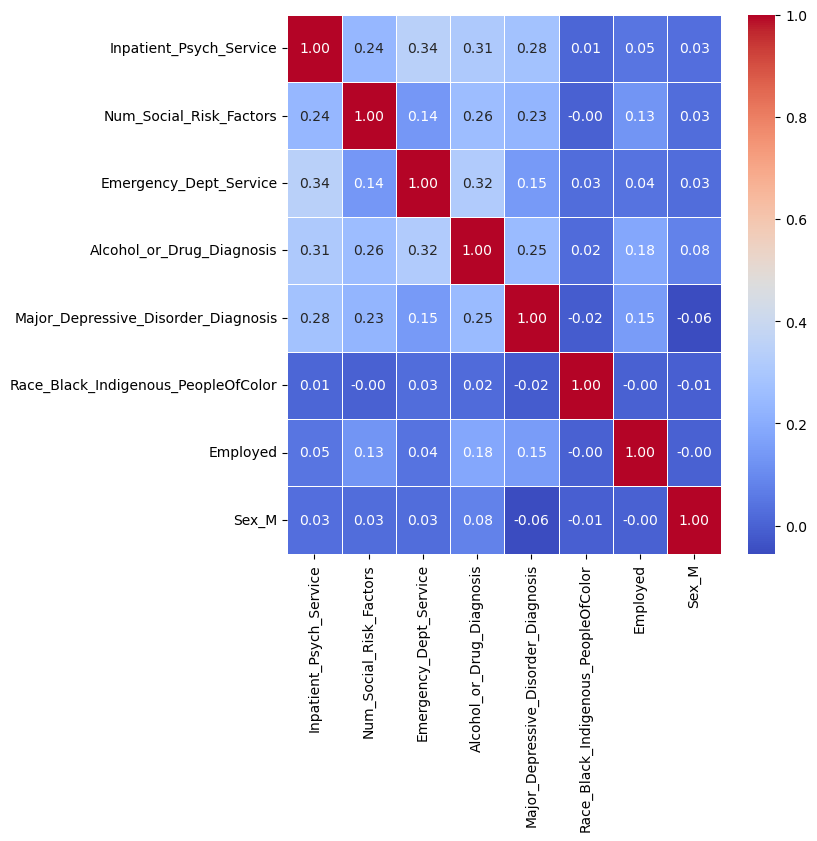

In [16]:
correlation_matrix = CHO1_df.corr()
plt.figure(figsize=(7,7))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            linewidths=0.5)
plt.show()

There is mostly very low correlation. The combinations that exceed .30, which is still a weak correlation, are:

- ED Svc & IP Psych Service
- Alcohol and Drug Use & IP Psych Svc
- Alcohol and Drug Use & ED Service

These results indicate that there is a low risk of colinearity.

## Sampling

In [17]:
x = CHO1_df.drop('Inpatient_Psych_Service',axis=1).copy()
x.head()

,Num_Social_Risk_Factors,Emergency_Dept_Service,Alcohol_or_Drug_Diagnosis,Major_Depressive_Disorder_Diagnosis,Race_Black_Indigenous_PeopleOfColor,Employed,Sex_M
0,0,0,0,0,0,0,False
1,0,1,1,1,0,0,True
2,0,0,0,0,0,0,False
3,1,0,1,0,0,0,False
4,0,1,0,0,0,0,False


In [18]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58279 entries, 0 to 58278
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   Num_Social_Risk_Factors              58279 non-null  int64
 1   Emergency_Dept_Service               58279 non-null  int64
 2   Alcohol_or_Drug_Diagnosis            58279 non-null  int64
 3   Major_Depressive_Disorder_Diagnosis  58279 non-null  int64
 4   Race_Black_Indigenous_PeopleOfColor  58279 non-null  int32
 5   Employed                             58279 non-null  int64
 6   Sex_M                                58279 non-null  bool 
dtypes: bool(1), int32(1), int64(5)
memory usage: 2.5 MB


In [19]:
y = CHO1_df['Inpatient_Psych_Service'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Inpatient_Psych_Service, dtype: object

In [20]:
y.unique()

array(['0', '1'], dtype=object)

In [21]:
class_counts = Counter(y)
total_samples = len(y)

class_percentages = {cls: count / total_samples * 100 for cls, 
                     count in class_counts.items()}

for cls, count in class_counts.items():
    percentage = class_percentages[cls]
    print(f"Class {cls}: Count = {count}, Percentage = {percentage:.2f}%")

Class 0: Count = 57000, Percentage = 97.81%
Class 1: Count = 1279, Percentage = 2.19%


### Over-sampling with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) is a technique used in machine learning and data preprocessing to address the class imbalance problem, particularly in classification tasks. The class imbalance problem arises when one class in the dataset has significantly fewer instances than the others, leading to biased models that may perform poorly on the minority class.

In Python, the imbalanced-learn library provides an implementation of SMOTE through the SMOTE class. Here's a brief explanation of what SMOTE does:

Identifying Minority Class Instances:
SMOTE focuses on the minority class, which is the class with fewer instances.

Generating Synthetic Samples:
For each instance in the minority class, SMOTE creates synthetic instances by interpolating between that instance and its k-nearest neighbors. The number of neighbors is specified by the user.

Balancing the Dataset:
The synthetic instances are added to the original dataset, effectively balancing the class distribution. This helps to mitigate the impact of class imbalance on machine learning models.

In [22]:
sm = SMOTE(sampling_strategy='minority')
x_sm , y_sm = sm.fit_resample(x,y)

In [23]:
x_sm.shape

(114000, 7)

In [24]:
y_sm.shape

(114000,)

In [25]:
y_sm.value_counts()

Inpatient_Psych_Service
0    57000
1    57000
Name: count, dtype: int64

In [26]:
# Check the shape of X_sm and y_sm
print(f"Shape of x_sm: {x_sm.shape}")
print(f"Shape of y_sm: {y_sm.shape}")

# If the number of samples is different, raise an error
if x_sm.shape[0] != y_sm.shape[0]:
    raise ValueError("X_sm and y_sm must have the same number of samples.")

Shape of x_sm: (114000, 7)
Shape of y_sm: (114000,)


### Train Test Split (Over Sampled)

In [44]:
xsm_train, xsm_test, ysm_train, ysm_test = train_test_split(x_sm, y_sm, random_state=37)

# Analysis (Over Sampled)

## Random Forrest (Over-Sampled)

Random Forest is an ensemble learning method in machine learning that operates by constructing a multitude of decision trees during training and outputs the mode of the classes for classification tasks or the mean prediction for regression tasks. Each decision tree is built on a random subset of the training data, and at each split, a random subset of features is considered. This randomness in the data and feature selection helps mitigate overfitting and increases the model's robustness. The final prediction is then determined by aggregating the predictions of all individual trees. Random Forest is known for its high accuracy, versatility, and ability to handle large datasets with numerous features, making it a popular choice for a wide range of machine learning applications.

### Define Forrest

In [45]:
# Select Random Forrest Classifier
random_forest_classifier = RandomForestClassifier()

In [52]:
# Set parameters
rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=20, 
                            criterion='entropy')

In [53]:
# Fit the training data
rf.fit(xsm_train, ysm_train)

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=200)

In [54]:
ysm_pred = rf.predict(xsm_test)

print(classification_report(ysm_test, ysm_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     14194
           1       0.88      0.94      0.91     14306

    accuracy                           0.90     28500
   macro avg       0.91      0.90      0.90     28500
weighted avg       0.91      0.90      0.90     28500



Results from the classification report of a Random Forest Classifier. Let's break down the key metrics:

- **Precision:**
  - Precision for class 0 (label 0): 0.93
    - This indicates that among the instances predicted as class 0, 93% were correctly classified.
  - Precision for class 1 (label 1): 0.88
    - Among instances predicted as class 1, 88% were correctly classified.

- **Recall:**
  - Recall for class 0: 0.87
    - Out of all instances that actually belong to class 0, 87% were correctly identified by the model.
  - Recall for class 1: 0.94
    - For class 1, 94% of actual instances were correctly identified.

- **F1-Score:**
  - F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics.
  - F1-score for class 0: 0.90
  - F1-score for class 1: 0.91

- **Support:**
  - The number of instances in each class (0 and 1) in the dataset.

- **Accuracy:**
  - Overall accuracy of the model on the entire dataset: 0.90 (or 90%)
    - This indicates the proportion of correctly classified instances out of the total.

- **Macro Average:**
  - The macro average of precision, recall, and F1-score across classes.
  - Macro average precision: 0.91, recall: 0.90, F1-score: 0.90

- **Weighted Average:**
  - The weighted average takes into account class imbalances.
  - Weighted average precision, recall, and F1-score: 0.91

In summary, the Random Forest Classifier is performing well, with high precision, recall, and F1-scores for both classes. The weighted average takes into consideration the class distribution in the dataset, providing an overall evaluation of the model's performance.

### Confusion Matrix

In [55]:
sm_conf_matrix = confusion_matrix(ysm_test, ysm_pred)
sm_conf_matrix

array([[12317,  1877],
       [  870, 13436]], dtype=int64)

These performance metrics indicate that the model has a high accuracy, precision, recall, specificity, and F1 score. Overall, the model seems to be performing well based on the provided confusion matrix. 

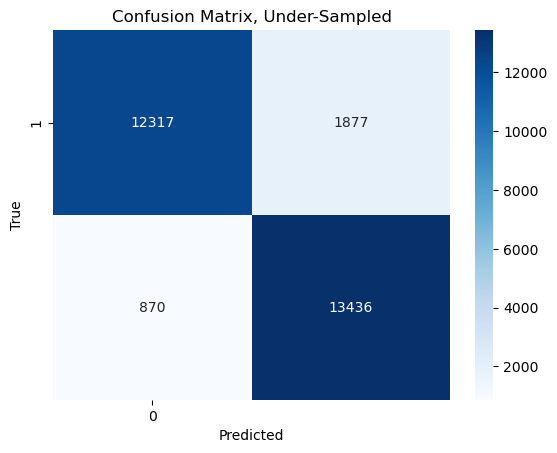

In [56]:
# Plot the confusion matrix using seaborn
sns.heatmap(sm_conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels='0', 
            yticklabels='1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix, Under-Sampled')
plt.show()

### Parameter Grid / Grid Search - SMOTE

#### Round 1

In [63]:
# Define parameter grid
sm_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'criterion': ['gini', 'entropy']
}

In [64]:
# Perform grid search
sm_grid_search = GridSearchCV(random_forest_classifier, 
                           param_grid=sm_param_grid, 
                           cv=5, 
                           n_jobs=-1)
sm_grid_search.fit(x_sm, y_sm)

# Print best parameters and score
print("Best parameters: ", sm_grid_search.best_params_)
print("Best score: ", sm_grid_search.best_score_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 200}
Best score:  0.9019912280701753


#### Round 2

In [65]:
# Define parameter grid
sm_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, 40],
    'criterion': ['gini', 'entropy']
}

In [66]:
# Perform grid search
sm_grid_search = GridSearchCV(random_forest_classifier, 
                           param_grid=sm_param_grid, 
                           cv=5, 
                           n_jobs=-1)
sm_grid_search.fit(x_sm, y_sm)

# Print best parameters and score
print("Best parameters: ", sm_grid_search.best_params_)
print("Best score: ", sm_grid_search.best_score_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 200}
Best score:  0.9019999999999999


### Round 3

In [42]:
# Define parameter grid
#sm_param_grid = {
#    'n_estimators': [10, 12, 14],
#    'max_depth': [18, 20, 22],
#    'criterion': ['gini']
#}

In [43]:
## Perform grid search
#sm_grid_search = GridSearchCV(random_forest_classifier, 
#                           param_grid=sm_param_grid, 
#                           cv=5, 
#                           n_jobs=-1)
#sm_grid_search.fit(x_sm, y_sm)
#
## Print best parameters and score
#print("Best parameters: ", sm_grid_search.best_params_)
#print("Best score: ", sm_grid_search.best_score_)

Best parameters:  {'criterion': 'gini', 'max_depth': 22, 'n_estimators': 14}
Best score:  0.9021842105263158


### Redefine Forrest Based on Best Parameters (Round 2)

In [69]:
# Set best parameters
rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=30, 
                            criterion='entropy')
# Fit Model
rf.fit(x_sm,y_sm)

RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=200)

In [70]:
ysm_pred=rf.predict(xsm_test)
print(classification_report(ysm_test, ysm_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     14194
           1       0.88      0.94      0.91     14306

    accuracy                           0.90     28500
   macro avg       0.91      0.90      0.90     28500
weighted avg       0.91      0.90      0.90     28500



### Compare Original Under-Sampled model to Optimized model

The results of the two random forest analyses on the same data, labeled as "Original" and "Optimized," exhibit identical performance metrics across precision, recall, and F1-score for both classes (0 and 1). 

The precision metric indicates the proportion of correctly predicted positive instances among all instances predicted as positive, the recall metric reflects the proportion of correctly predicted positive instances among all actual positive instances, and the F1-score is the harmonic mean of precision and recall. 

In both analyses, these metrics demonstrate balanced and high-quality predictions for both classes, with an accuracy of 90%. The macro and weighted averages across the two classes also consistently yield values around 0.91, indicating overall robust model performance. 

The similarity in results between the "Original" and "Optimized" models suggests that the optimization process did not significantly impact the classification performance, emphasizing the stability of the initial model's effectiveness on the given dataset.

In [71]:
sm_conf_matrix_final = confusion_matrix(ysm_test, ysm_pred)

print(sm_conf_matrix_final)

[[12327  1867]
 [  865 13441]]


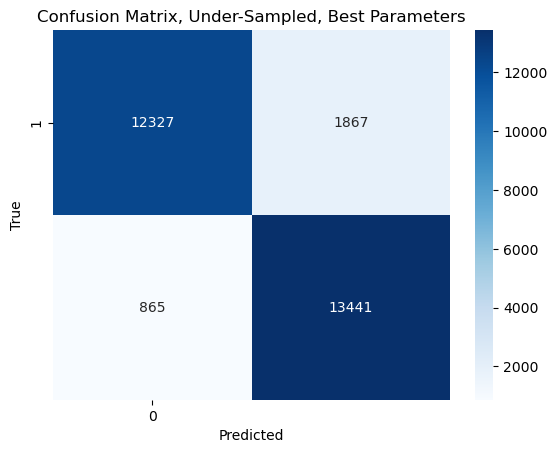

In [72]:
# Plot the confusion matrix using seaborn
sns.heatmap(sm_conf_matrix_final, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels='0', 
            yticklabels='1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix, Under-Sampled, Best Parameters')
plt.show()

## Under-sampling with NearMiss

In [73]:
nm = NearMiss(version=1)

In [74]:
x_nm, y_nm = nm.fit_resample(x,y)

In [75]:
x_nm.shape

(2558, 7)

In [76]:
y_nm.shape

(2558,)

In [77]:
y_nm.value_counts()

Inpatient_Psych_Service
0    1279
1    1279
Name: count, dtype: int64

In [78]:
# Check the shape of X_sm and y_sm
print(f"Shape of x_nm: {x_nm.shape}")
print(f"Shape of y_nm: {y_nm.shape}")

# If the number of samples is different, raise an error
if x_nm.shape[0] != y_nm.shape[0]:
    raise ValueError("X_nm and y_nm must have the same number of samples.")

Shape of x_nm: (2558, 7)
Shape of y_nm: (2558,)


In [79]:
xnm_train, xnm_test, ynm_train, ynm_test = train_test_split(x_nm, y_nm, random_state=37)

# Analysis (Under-Sampled)

## Random Forest (Under-Sampled)

Random Forest is an ensemble learning method in machine learning that operates by constructing a multitude of decision trees during training and outputs the mode of the classes for classification tasks or the mean prediction for regression tasks. Each decision tree is built on a random subset of the training data, and at each split, a random subset of features is considered. This randomness in the data and feature selection helps mitigate overfitting and increases the model's robustness. The final prediction is then determined by aggregating the predictions of all individual trees. Random Forest is known for its high accuracy, versatility, and ability to handle large datasets with numerous features, making it a popular choice for a wide range of machine learning applications.

In [80]:
# Select Random Forrest Classifier
random_forest_classifier = RandomForestClassifier()

In [81]:
# Set parameters
rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=None, 
                            criterion='entropy')

In [82]:
# Fit the training data
rf.fit(xnm_train, ynm_train)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [83]:
ynm_pred = rf.predict(xnm_test)

print(classification_report(ynm_test, ynm_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       324
           1       0.84      0.87      0.85       316

    accuracy                           0.85       640
   macro avg       0.85      0.85      0.85       640
weighted avg       0.85      0.85      0.85       640



The results provided are the classification metrics for a Random Forest classifier applied to a dataset. Let's break down the interpretation:

Precision: The precision for class 0 is 0.86, indicating that 86% of instances predicted as class 0 were true positives. For class 1, the precision is 0.84, meaning that 84% of instances predicted as class 1 were true positives. Precision measures the accuracy of positive predictions.

Recall (Sensitivity): The recall for class 0 is 0.84, suggesting that the model correctly identified 84% of the actual positive instances for class 0. For class 1, the recall is 0.86, indicating that 86% of actual positive instances for class 1 were correctly identified. Recall measures the ability of the model to capture all instances of the positive class.

F1-score: The F1-score is the harmonic mean of precision and recall. Both classes have an F1-score of 0.85, reflecting a balanced trade-off between precision and recall.

Accuracy: The overall accuracy is 0.85, indicating the proportion of correctly classified instances among all instances.

Macro-average: The macro-average is the average of precision, recall, and F1-score across classes. In this case, it is also 0.85, suggesting balanced performance across both classes.

Weighted-average: The weighted-average is an average where each class contribution is weighted by its support (the number of true instances). The weighted-average is 0.85, indicating consistent performance across the entire dataset.

In summary, the Random Forest classifier demonstrates good overall performance with balanced precision, recall, and F1-scores for both classes, resulting in a high accuracy of 85%. The macro and weighted averages further support the model's stability and effectiveness across the dataset.

In [84]:
nm_conf_matrix = confusion_matrix(ynm_test, ynm_pred)
nm_conf_matrix

array([[271,  53],
       [ 42, 274]], dtype=int64)

Overall, the model shows good performance with a balanced distribution of correct predictions in both classes, as evidenced by the similar values in the true positive and true negative regions of the confusion matrix.

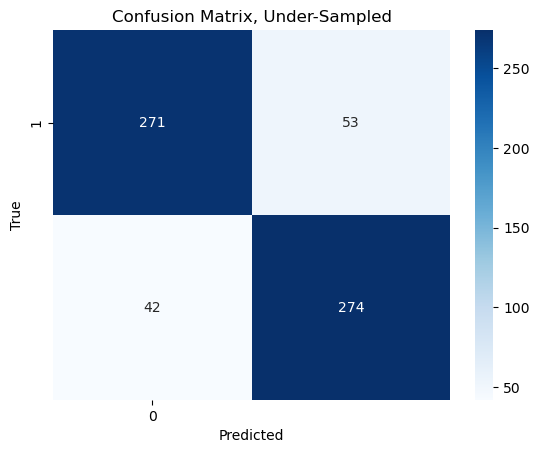

In [85]:
# Plot the confusion matrix using seaborn
sns.heatmap(nm_conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels='0', 
            yticklabels='1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix, Under-Sampled')
plt.show()

## Parameter Grid / Grid Search

### Round 1

In [86]:
# Define parameter grid
nm_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15],
    'criterion': ['gini', 'entropy']
}

In [87]:
# Perform grid search
nm_grid_search = GridSearchCV(random_forest_classifier, 
                           param_grid=nm_param_grid, 
                           cv=5, 
                           n_jobs=-1)
nm_grid_search.fit(x_nm, y_nm)

# Print best parameters and score
print("Best parameters: ", nm_grid_search.best_params_)
print("Best score: ", nm_grid_search.best_score_)

Best parameters:  {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200}
Best score:  0.8529958109099803


### Round 2

In [90]:
# Define parameter grid
nm_param_grid = {
    'n_estimators': [0, 20, 40],
    'max_depth': [3, 5, 7],
    'criterion': ['gini', 'entropy']
}

In [91]:
# Perform grid search
nm_grid_search = GridSearchCV(random_forest_classifier, 
                           param_grid=nm_param_grid, 
                           cv=5, 
                           n_jobs=-1)
nm_grid_search.fit(x_nm, y_nm)

# Print best parameters and score
print("Best parameters: ", nm_grid_search.best_params_)
print("Best score: ", nm_grid_search.best_score_)

Best parameters:  {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 40}
Best score:  0.8526013637475538


C:\Users\KGLtd\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\KGLtd\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\KGLtd\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\KGLtd\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\KGLtd\anaconda3\Lib\site-packages\

### Round 3

In [92]:
# Define parameter grid
nm_param_grid = {
    'n_estimators': [30, 40, 50],
    'max_depth': [2, 3, 4],
    'criterion': ['gini']
}

In [93]:
# Perform grid search
nm_grid_search = GridSearchCV(random_forest_classifier, 
                           param_grid=nm_param_grid, 
                           cv=5, 
                           n_jobs=-1)
nm_grid_search.fit(x_nm, y_nm)

# Print best parameters and score
print("Best parameters: ", nm_grid_search.best_params_)
print("Best score: ", nm_grid_search.best_score_)

Best parameters:  {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 30}
Best score:  0.8568990031800391


### Redefine Forrest Based on Best Parameters (Round 3)

In [94]:
# Set Best Parameters
# Round 3
rf = RandomForestClassifier(n_estimators=30, 
                            max_depth=4, 
                            criterion='gini')

In [95]:
# Fit Model
rf.fit(x_nm,y_nm)

RandomForestClassifier(max_depth=4, n_estimators=30)

In [96]:
y_pred=rf.predict(xnm_test)
print(classification_report(ynm_test, ynm_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       324
           1       0.84      0.87      0.85       316

    accuracy                           0.85       640
   macro avg       0.85      0.85      0.85       640
weighted avg       0.85      0.85      0.85       640



### Compare Original Under-Sampled to Optimized Under-Sampled

The results of the two random forest models, Original and Optimized, are identical based on the provided precision, recall, and f1-score metrics. 

Both models demonstrate consistent performance across the two classes (0 and 1), achieving an accuracy of 85%. The precision and recall values for both classes are also the same, indicating that both models have an equal ability to correctly identify instances of both classes. The macro and weighted averages for precision, recall, and f1-score are all consistent, reaffirming the balanced performance of both models across the entire dataset. 

Overall, there is no observable difference in performance between the Original and Optimized random forest models based on the given evaluation metrics.

## Compare Over-Sampled with Under-Sampled Random Forest models

The results of the two random forest models, Over-Sampled and Under-Sampled, indicate differences in performance due to the different sampling techniques employed:

**Over-Sampled Model:**
- Precision: The model exhibits high precision for both classes (0 and 1), with 93% for class 0 and 88% for class 1.
- Recall: The model demonstrates high recall, particularly for class 1 (94%), indicating its ability to correctly identify instances of this minority class.
- F1-Score: The balanced F1-scores of 90% for both classes suggest an overall well-rounded performance.
- Accuracy: The overall accuracy is 90%, reflecting the model's effectiveness across the entire dataset.

**Under-Sampled Model:**
- Precision: The precision for both classes is slightly lower compared to the Over-Sampled model, with 87% for class 0 and 84% for class 1.
- Recall: Similar to precision, recall is slightly lower for both classes, with 84% for class 0 and 87% for class 1.
- F1-Score: The balanced F1-scores of 85% for both classes indicate a relatively balanced performance.
- Accuracy: The overall accuracy is 85%, reflecting the model's effectiveness on the reduced dataset.

**Comparison:**
- The Over-Sampled model generally outperforms the Under-Sampled model in terms of precision, recall, and F1-score.
- The Over-Sampled model achieves a higher accuracy of 90% compared to the Under-Sampled model's accuracy of 85%.
- The choice between Over-Sampling and Under-Sampling depends on the specific goals and constraints of the problem at hand, as well as the trade-offs between performance metrics and computational resources.

## XGBoost

XGBoost (Extreme Gradient Boosting) is a popular machine learning algorithm that is particularly effective for structured/tabular data and is widely used for both classification and regression tasks. 

### Wrangle Data

Convert Inpatient Psych Services back to numerical

In [98]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

### Split Data

In [99]:
xbst_train, xbst_test, ybst_train, ybst_test = train_test_split(x, y_encoded, test_size=0.2, random_state=37)

### Define XGBoost model

In [100]:
XGBmodel = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=37
)

### Train the model

In [101]:
XGBmodel.fit(xbst_train, ybst_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Make Predications

In [102]:
ybst_pred = XGBmodel.predict(xbst_test)

### Evaluate Model

In [103]:
accuracy = accuracy_score(ybst_test, ybst_pred)
report = classification_report(ybst_test, ybst_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.9807824296499656
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11405
           1       0.64      0.24      0.35       251

    accuracy                           0.98     11656
   macro avg       0.81      0.62      0.67     11656
weighted avg       0.98      0.98      0.98     11656



Accuracy: 0.9808

This metric represents the overall correctness of the model. In this case, the model achieves an accuracy of approximately 98.08%, indicating that it correctly predicted the class for 98.08% of the instances.
Classification Report:

Precision: Precision is the ratio of true positive predictions to the total predicted positives.

Class 0: 98% precision, suggesting that when the model predicts class 0, it is correct 98% of the time.
Class 1: 64% precision, indicating that the model's predictions for class 1 are correct 64% of the time.
Recall: Recall is the ratio of true positive predictions to the total actual positives.

Class 0: 100% recall, meaning the model correctly identifies all instances of class 0.
Class 1: 24% recall, indicating that the model captures only 24% of the instances of class 1.
F1-Score: The F1-score is the harmonic mean of precision and recall, providing a balanced measure of a classifier's performance.

Class 0: 99% F1-score.
Class 1: 35% F1-score.
Support: The number of actual occurrences of each class in the test set.

Class 0: 11,405 instances.
Class 1: 251 instances.
Summary:

The high accuracy suggests that the model is performing well on the majority class (class 0), but it struggles with the minority class (class 1), as indicated by lower precision, recall, and F1-score for class 1. The imbalanced nature of the classes (with significantly more instances of class 0 than class 1) might be contributing to this behavior.

Depending on the specific application and the importance of correctly predicting class 1 instances, further model tuning, data balancing techniques, or different evaluation metrics may be considered.

### Feature Importance

In [104]:
feature_importance = pd.DataFrame({'feature': x.columns, 'importance': XGBmodel.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print(feature_importance)


                               feature  importance
2            Alcohol_or_Drug_Diagnosis    0.396244
1               Emergency_Dept_Service    0.283481
3  Major_Depressive_Disorder_Diagnosis    0.222734
0              Num_Social_Risk_Factors    0.058703
4  Race_Black_Indigenous_PeopleOfColor    0.014979
6                                Sex_M    0.011954
5                             Employed    0.011906


The feature importance results provide insights into the contribution of each feature in the XGBoost model's decision-making process. In this context, the values in the "importance" column represent the relative importance of each feature in making predictions. Here's an interpretation of the results:

Alcohol_or_Drug_Diagnosis (Importance: 39.62%):
This feature has the highest importance, suggesting that it significantly influences the model's predictions. The presence or absence of Alcohol or Drug Diagnosis has a substantial impact on the model's decision-making.

Emergency_Dept_Service (Importance: 28.35%):
The Emergency Department Service feature is the second most important. This implies that whether a person received emergency department services is a crucial factor in predicting the target variable.

Major_Depressive_Disorder_Diagnosis (Importance: 22.27%):
This feature has a considerable importance level, indicating that the presence or absence of a Major Depressive Disorder Diagnosis is a significant predictor in the model.

Num_Social_Risk_Factors (Importance: 5.87%):
Although relatively less important compared to the top three features, the number of social risk factors still contributes to the model's predictions.

Race_Black_Indigenous_PeopleOfColor (Importance: 1.50%):
The racial category of Black or Indigenous People of Color has a lower importance compared to the top features but still contributes to the model.

Sex_M (Importance: 1.20%):
The gender (male) is a less influential feature compared to others but still plays a role in the model's decision-making.

Employed (Importance: 1.19%):
Employment status is the least important feature in this set, but it still adds some information to the model.

These results suggest that the model relies heavily on the first three features, particularly "Alcohol_or_Drug_Diagnosis" and "Emergency_Dept_Service," to make predictions. Understanding the importance of these features can help in interpreting the model's behavior and guide further investigation or decision-making based on the context of the problem you're addressing.

### Perform Cross Validation

In [105]:
# Perform cross-validation
kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=37)

cv_results = cross_val_score(XGBmodel, 
                             xbst_test, 
                             ybst_test, 
                             cv=kfold, 
                             scoring='accuracy')

# Print results
print(f"Cross-Validation Accuracy: {cv_results.mean():.4f} (±{cv_results.std():.4f})")

Cross-Validation Accuracy: 0.9810 (±0.0010)


### Feature Importance Plot

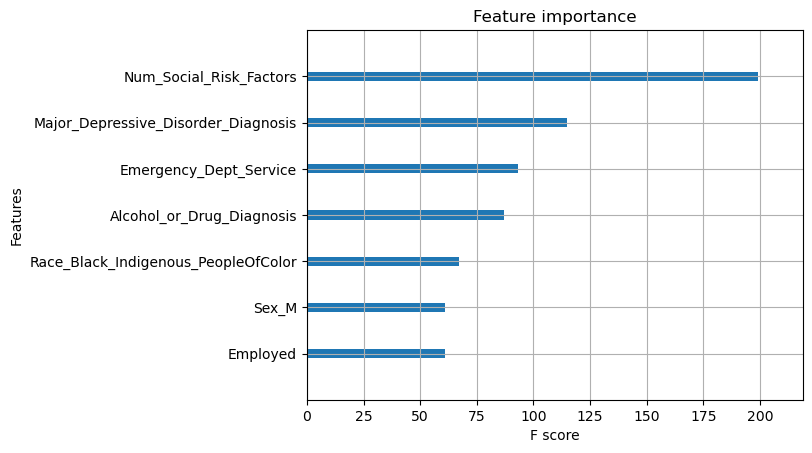

In [106]:
xgb.plot_importance(XGBmodel, 
                    importance_type='weight', 
                    show_values=False)
plt.errorbar(range(len(XGBmodel.feature_importances_)), 
             XGBmodel.feature_importances_, 
             yerr=cv_results.std(), 
             fmt='none', 
             ecolor='red', 
             lw=2)
plt.show()